# Análise de Gêneros Musicais com LVQ no Spotify

In [1]:
!pip install matplotlib

In [4]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from csv import reader
from random import randrange
from math import sqrt

# Load a CSV file
def load_csv(filename):
    dataset = list()
    with open(filename, 'r') as file:
        csv_reader = reader(file)
        for row in csv_reader:
            if not row:
                continue
            dataset.append(row)
    return dataset

# Convert string column to float
def str_column_to_float(dataset, column):
    for row in dataset:
        if row[column].strip().replace('.', '', 1).isdigit():  # Check if the string is a float
            row[column] = float(row[column].strip())

# Convert string column to integer
def str_column_to_int(dataset, column):
    class_values = [row[column] for row in dataset]
    unique = set(class_values)
    lookup = dict()
    for i, value in enumerate(unique):
        lookup[value] = i
    for row in dataset:
        row[column] = lookup[row[column]]
    return lookup, dataset

# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)

    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': [], 'model': [], 'test_set': []}

    for i in range(n_folds):
        train_set = sum(folds[:i] + folds[i+1:], [])
        valid_set = folds[i][:len(folds[i]) // 2]
        test_set = folds[i][len(folds[i]) // 2:]

        model = algorithm(train_set, valid_set, *args)
        scores['model'].append(model)

        train_actual = [row[-1] for row in train_set]
        train_predicted = [predict(model, row[:-1]) for row in train_set]

        valid_actual = [row[-1] for row in valid_set]
        valid_predicted = [predict(model, row[:-1]) for row in valid_set]

        test_actual = [row[-1] for row in test_set]
        test_predicted = [predict(model, row[:-1]) for row in test_set]

        scores['accuracy'].append({'train': accuracy_metric(train_actual, train_predicted),
                                   'valid': accuracy_metric(valid_actual, valid_predicted),
                                   'test': accuracy_metric(test_actual, test_predicted)})

        scores['precision'].append({'train': precision_metric(train_actual, train_predicted),
                                    'valid': precision_metric(valid_actual, valid_predicted),
                                    'test': precision_metric(test_actual, test_predicted)})

        scores['recall'].append({'train': recall_metric(train_actual, train_predicted),
                                 'valid': recall_metric(valid_actual, valid_predicted),
                                 'test': recall_metric(test_actual, test_predicted)})

        scores['f1_score'].append({'train': f1_score_metric(train_actual, train_predicted),
                                   'valid': f1_score_metric(valid_actual, valid_predicted),
                                   'test': f1_score_metric(test_actual, test_predicted)})

        scores['test_set'].append(test_set)

    return scores

# Calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
    distance = 0.0
    for i in range(len(row1)-1):  # Excluindo a última coluna que é o rótulo/classe
        try:
            if isinstance(row1[i], float) and isinstance(row2[i], float):
                diff = row1[i] - row2[i]
                distance += np.square(diff)  # Usando np.square para calcular o quadrado da diferença
        except TypeError:
            print(f"TypeError at index {i}: row1={row1[i]}, row2={row2[i]}")
            continue
    return np.sqrt(distance)

# Locate the best matching unit
def get_best_matching_unit(codebooks, test_row):
    distances = list()
    for codebook in codebooks:
        dist = euclidean_distance(codebook, test_row)
        distances.append((codebook, dist))
    distances.sort(key=lambda tup: tup[1])
    return distances[0][0]

# Make a prediction with codebook vectors
def predict(codebooks, test_row):
    bmu = get_best_matching_unit(codebooks, test_row)
    return bmu[-1]

# Create a random codebook vector
def random_codebook(train):
    n_records = len(train)
    n_features = len(train[0])
    codebook = [train[randrange(n_records)][i] for i in range(n_features)]
    return codebook

# Train a set of codebook vectors
def train_codebooks(train, n_codebooks, lrate, epochs):
    codebooks = [random_codebook(train) for _ in range(n_codebooks)]
    for epoch in range(epochs):
        rate = lrate * (1.0-(epoch/float(epochs)))
        for row in train:
            bmu = get_best_matching_unit(codebooks, row)
            for i in range(len(row)-1):  # Excluindo a última coluna que é o rótulo/classe
                try:
                    if isinstance(row[i], float) and isinstance(bmu[i], float):
                        error = row[i] - bmu[i]
                        if bmu[-1] == row[-1]:
                            bmu[i] += rate * error
                        else:
                            bmu[i] -= rate * error
                except TypeError:
                    print(f"TypeError at index {i}: row={row[i]}, bmu={bmu[i]}")
                    continue
    return codebooks


# LVQ Algorithm
def learning_vector_quantization(train, valid, n_codebooks, lrate, epochs):
    codebooks = train_codebooks(train, n_codebooks, lrate, epochs)
    return codebooks

# Update precision metric
def precision_metric(actual, predicted):
    return precision_score(actual, predicted, average='weighted', zero_division=0)

# Update recall metric
def recall_metric(actual, predicted):
    return recall_score(actual, predicted, average='weighted')

# Update F1 score metric
def f1_score_metric(actual, predicted):
    return f1_score(actual, predicted, average='weighted')

# Load and prepare data
filename = "spotify_dataset.csv"
dataset = load_csv(filename)

for i in range(len(dataset[0])):
    str_column_to_float(dataset, i)

class_lookup, dataset = str_column_to_int(dataset, len(dataset[0])-1)

# Evaluate algorithm
n_folds = 5
learn_rate = 0.3
n_epochs = 50
n_codebooks = 15

scores = evaluate_algorithm(dataset, learning_vector_quantization, n_folds, n_codebooks, learn_rate, n_epochs)

metrics = ['accuracy', 'precision', 'recall', 'f1_score']

for metric in metrics:
    print(f"{metric.capitalize()} scores:")
    mean_train = sum(score['train'] for score in scores[metric]) / n_folds
    mean_valid = sum(score['valid'] for score in scores[metric]) / n_folds
    mean_test = sum(score['test'] for score in scores[metric]) / n_folds
    print(f"Mean Train: {mean_train:.3f}, Mean Valid: {mean_valid:.3f}, Mean Test: {mean_test:.3f}")

<ipython-input-4-d34260d44d83>:110: RuntimeWarning: overflow encountered in scalar add
  distance += np.square(diff)  # Usando np.square para calcular o quadrado da diferença
<ipython-input-4-d34260d44d83>:110: RuntimeWarning: overflow encountered in square
  distance += np.square(diff)  # Usando np.square para calcular o quadrado da diferença
<ipython-input-4-d34260d44d83>:110: RuntimeWarning: overflow encountered in scalar add
  distance += np.square(diff)  # Usando np.square para calcular o quadrado da diferença
<ipython-input-4-d34260d44d83>:110: RuntimeWarning: overflow encountered in square
  distance += np.square(diff)  # Usando np.square para calcular o quadrado da diferença
<ipython-input-4-d34260d44d83>:110: RuntimeWarning: overflow encountered in scalar add
  distance += np.square(diff)  # Usando np.square para calcular o quadrado da diferença
<ipython-input-4-d34260d44d83>:110: RuntimeWarning: overflow encountered in square
  distance += np.square(diff)  # Usando np.square 

Accuracy scores:
Mean Train: 9.261, Mean Valid: 9.590, Mean Test: 9.562
Precision scores:
Mean Train: 0.009, Mean Valid: 0.009, Mean Test: 0.009
Recall scores:
Mean Train: 0.093, Mean Valid: 0.096, Mean Test: 0.096
F1_score scores:
Mean Train: 0.016, Mean Valid: 0.017, Mean Test: 0.017



Available keys in scores:
dict_keys(['accuracy', 'precision', 'recall', 'f1_score', 'model', 'test_set'])


<ipython-input-4-d34260d44d83>:110: RuntimeWarning: overflow encountered in scalar add
  distance += np.square(diff)  # Usando np.square para calcular o quadrado da diferença
<ipython-input-4-d34260d44d83>:110: RuntimeWarning: overflow encountered in square
  distance += np.square(diff)  # Usando np.square para calcular o quadrado da diferença


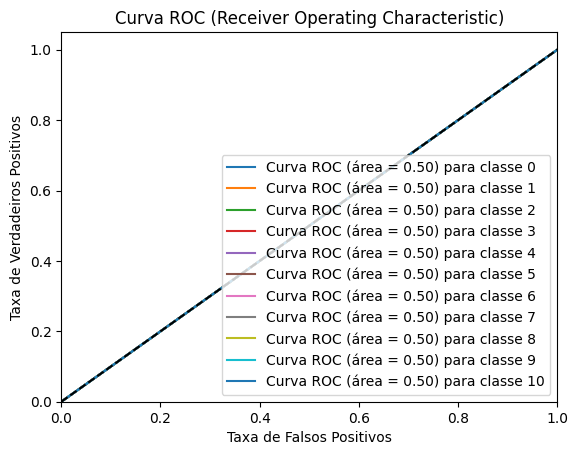

In [5]:
# Print available keys in scores
print("\nAvailable keys in scores:")
print(scores.keys())

# Extract codebooks and test set from scores
if 'model' in scores:
    codebooks = scores['model'][-1]
else:
    print("Key 'model' not found in scores.")

# Extract test set from scores
if 'test_set' in scores:
    test_set = scores['test_set'][-1]
else:
    print("Key 'test_set' not found in scores.")
    exit()

# Extract codebooks from the last fold's model
if 'model' in scores:
    codebooks = scores['model'][-1]
else:
    print("Key 'model' not found in scores.")
    exit()

# Predict probabilities
def predict_probabilities(codebooks, test_row):
    bmu = get_best_matching_unit(codebooks, test_row)
    codebook_class = bmu[-1]
    probabilities = [0] * (len(bmu) - 1)
    probabilities[codebook_class] = 1
    return probabilities

test_probabilities = [predict_probabilities(codebooks, row[:-1]) for row in test_set]
test_actual = [row[-1] for row in test_set]

# Convert test_actual and test_probabilities to one-hot encoding
test_probabilities = [predict_probabilities(codebooks, row[:-1]) for row in test_set]
test_actual = [row[-1] for row in test_set]

# Convert test_actual and test_probabilities to one-hot encoding
test_actual_one_hot = pd.get_dummies(test_actual).values
test_probabilities_array = np.array(test_probabilities)

# Calculate ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(test_actual_one_hot[0])):
    fpr[i], tpr[i], _ = roc_curve(test_actual_one_hot[:, i], test_probabilities_array[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Plot ROC curve
plt.figure()
for i in range(len(test_actual_one_hot[0])):
    plt.plot(fpr[i], tpr[i], label=f'Curva ROC (área = {roc_auc[i]:.2f}) para classe {i}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC (Receiver Operating Characteristic)')
plt.legend(loc="lower right")
plt.show()